In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define the base directory
base_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['Uninfected', 'Parasitized', 'cell_images']


In [3]:
# Define the base directory
base_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Initialize a dictionary to hold counts for each class
class_counts = {'Uninfected': 0, 'Parasitized': 0}

# Loop through each class folder and count the files
for class_name in class_counts.keys():
    class_dir = os.path.join(base_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))  # Count files in the directory

# Display the counts
print("Sample counts for each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")



Sample counts for each class:
Uninfected: 13780 samples
Parasitized: 13780 samples


In [4]:
from PIL import Image, UnidentifiedImageError
import os
import shutil

# Define the base directory and the working directory
base_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'
working_dir = '/kaggle/working/verified_images'  # Directory to store verified images

# Create the working directory if it doesn't exist
os.makedirs(working_dir, exist_ok=True)

# Initialize a dictionary to hold counts for each class
class_counts = {'Uninfected': 0, 'Parasitized': 0}
invalid_images = []  # To store the paths of invalid images

# Loop through each class folder and check the validity of images
for class_name in class_counts.keys():
    class_dir = os.path.join(base_dir, class_name)
    
    # Get the list of files in the class directory
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        
        # Try to open the image to check if it is valid
        try:
            with Image.open(file_path) as img:
                img.verify()  # This will raise an exception if the image is invalid
            
            # Increment the count for valid images
            class_counts[class_name] += 1
            
            # Create a class subdirectory in the working directory if it doesn't exist
            class_verified_dir = os.path.join(working_dir, class_name)
            os.makedirs(class_verified_dir, exist_ok=True)
            
            # Copy the verified image to the working directory
            shutil.copy(file_path, class_verified_dir)  # Copy the verified image
        except (UnidentifiedImageError, IOError, SyntaxError) as e:
            invalid_images.append(file_path)  # Store the path of the invalid image
            print(f"Skipped invalid image: {file_path}")  # Print confirmation of skipping

# Display the counts of valid images
print("Valid image counts for each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} valid samples")

# Display total number of invalid images skipped
print(f"\nTotal invalid images skipped: {len(invalid_images)}")


Skipped invalid image: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/Thumbs.db
Skipped invalid image: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/Thumbs.db
Valid image counts for each class:
Uninfected: 13779 valid samples
Parasitized: 13779 valid samples

Total invalid images skipped: 2


In [5]:
# Define the working directory
working_dir = '/kaggle/working/verified_images'  # Directory where valid images are stored

# Initialize a dictionary to hold counts for each class
class_counts = {}

# Loop through each class folder in the working directory
for class_name in os.listdir(working_dir):
    class_dir = os.path.join(working_dir, class_name)  # Get the full path of the class directory
    
    if os.path.isdir(class_dir):  # Check if it's a directory
        # Count the number of image files in the class directory
        image_count = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
        class_counts[class_name] = image_count  # Store the count for the class

# Display the counts of images for each class
print("Image counts in each class folder:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Image counts in each class folder:
Uninfected: 13779 images
Parasitized: 13779 images


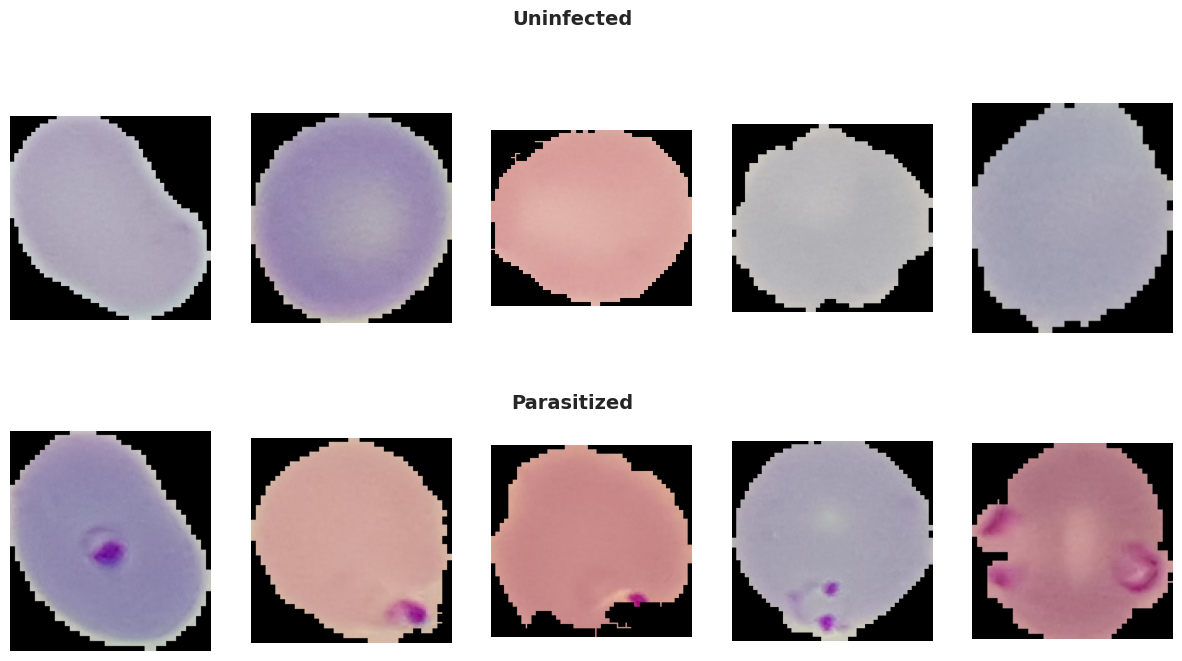

In [6]:
# Number of images to display per class
num_samples = 5

# Create plot with extra spacing for the subheaders
fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
fig.subplots_adjust(top=0.85)  # Adjust top margin for extra space

# Titles for each row
class_titles = ["Uninfected", "Parasitized"]

# Loop through classes and plot sample images
for i, class_name in enumerate(class_counts.keys()):
    class_dir = os.path.join(working_dir, class_name)
    image_files = os.listdir(class_dir)[:num_samples]
    
    # Add a centered title above each row of images
    fig.text(0.5, 0.93 - i * 0.48, class_titles[i], ha='center', va='center', fontsize=14, weight='bold')
    
    for j, img_name in enumerate(image_files):
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path)

        # Display image
        axes[i, j].imshow(image)
        axes[i, j].axis('off')

plt.show()


In [7]:
class Malaria_Dataset(Dataset): 
    def __init__(self, data_df, transform=None):
        """
        Args:
            data_df (DataFrame): DataFrame containing image paths and labels for the dataset.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = data_df[['image_path', 'label']].values
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label  # Return the image and its label

In [8]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])
# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
# Define class names
classes = ['Uninfected', 'Parasitized']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}

In [10]:
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to labels
for cls in classes:
    images_dir = os.path.join(working_dir, cls) 
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)  
        all_mapped_data.append((img_path, label_mapping[cls]))  

# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")


Mapped DataFrame:


,image_path,label
0,/kaggle/working/verified_images/Uninfected/C21...,0
1,/kaggle/working/verified_images/Uninfected/C14...,0
2,/kaggle/working/verified_images/Uninfected/C10...,0
3,/kaggle/working/verified_images/Uninfected/C16...,0
4,/kaggle/working/verified_images/Uninfected/C16...,0


Total images mapped: 27558


Image counts per class:
Uninfected: 13779 images
Parasitized: 13779 images
Mapped counts per class:
Uninfected: 13779 images (Mapped)
Parasitized: 13779 images (Mapped)
No duplicate entries found.
All labels are valid.


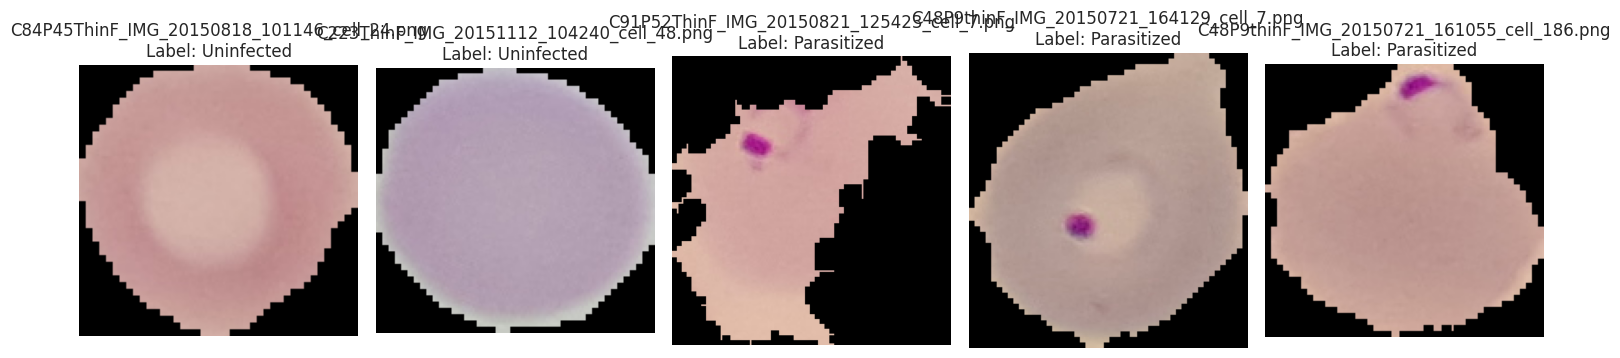

In [11]:
# 1. Verify Count of Images
image_counts = {cls: len(os.listdir(os.path.join(working_dir, cls))) for cls in classes}
print("Image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")

# Compare counts with DataFrame
mapped_count = mapped_df['label'].value_counts().to_dict()
print("Mapped counts per class:")
for cls, count in mapped_count.items():
    print(f"{classes[cls]}: {count} images (Mapped)")

# 2. Check for Duplicates
duplicates = mapped_df[mapped_df.duplicated(subset=['image_path'], keep=False)]
if not duplicates.empty:
    print(f"Found {duplicates.shape[0]} duplicate entries.")
else:
    print("No duplicate entries found.")

# 3. Validate Labels
incorrect_labels = mapped_df[~mapped_df['label'].isin([0, 1])]
if not incorrect_labels.empty:
    print(f"Found {incorrect_labels.shape[0]} entries with incorrect labels.")
else:
    print("All labels are valid.")

# 4. Display Sample Images for Visual Inspection
def display_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    sample_images = df.sample(num_samples, random_state=42)  # Randomly sample images
    for i, (idx, row) in enumerate(sample_images.iterrows()):
        img_path = row['image_path']
        img_name = os.path.basename(img_path)  # Get just the file name
        label = classes[row['label']]  # Get the label name
        
        # Open the image
        img = Image.open(img_path)
        
        plt.subplot(1, num_samples, i + 1)  # Adjust subplot for 1 row
        plt.imshow(img)
        plt.title(f"{img_name}\nLabel: {label}")  # Show image name and label
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Display a few sample images along with their names and labels
display_sample_images(mapped_df, num_samples=5)

In [12]:
# Shuffle the DataFrame
mapped_df = mapped_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate sizes
total_size = len(mapped_df)
train_size = int(0.7 * total_size)
temp_size = total_size - train_size
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split into train and temporary (30% for validation and testing)
train_df = mapped_df.iloc[:train_size]
temp_df = mapped_df.iloc[train_size:]

# Further split temporary into validation and testing
val_df = temp_df.iloc[:val_size]
test_df = temp_df.iloc[val_size:]

# Print sizes of each set
print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Total samples: 27558
Training samples: 19290
Validation samples: 2755
Testing samples: 5513


In [13]:
# Check the structure of train_data by printing a few samples
print("Sample structure of train_data:")
for i in range(min(5, len(train_df))):  # Print at most 5 samples
    print(f"Index {i}: {train_df.iloc[i]}")  # Use iloc to access rows

Sample structure of train_data:
Index 0: image_path    /kaggle/working/verified_images/Uninfected/C84...
label                                                         0
Name: 0, dtype: object
Index 1: image_path    /kaggle/working/verified_images/Uninfected/C22...
label                                                         0
Name: 1, dtype: object
Index 2: image_path    /kaggle/working/verified_images/Parasitized/C9...
label                                                         1
Name: 2, dtype: object
Index 3: image_path    /kaggle/working/verified_images/Parasitized/C4...
label                                                         1
Name: 3, dtype: object
Index 4: image_path    /kaggle/working/verified_images/Parasitized/C4...
label                                                         1
Name: 4, dtype: object


In [14]:
# Extract labels from the training DataFrame
train_labels = train_df['label'].values

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([0.9961, 1.0040])


In [15]:
# Define batch size and number of workers
batch_size = 16
num_workers = 4 

# Initialize KFold for 5-fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    print(f"\nFold {fold + 1}")
    print(f"Training samples in fold: {len(train_fold)}")
    print(f"Validation samples in fold: {len(val_fold)}")


Fold 1
Training samples in fold: 15432
Validation samples in fold: 3858

Fold 2
Training samples in fold: 15432
Validation samples in fold: 3858

Fold 3
Training samples in fold: 15432
Validation samples in fold: 3858

Fold 4
Training samples in fold: 15432
Validation samples in fold: 3858

Fold 5
Training samples in fold: 15432
Validation samples in fold: 3858


In [16]:
# Create the test dataset using the test DataFrame
test_dataset = Malaria_Dataset(data_df=test_df, transform=val_test_transform)

# Initialize KFold for 5-fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    print(f"\nFold {fold + 1}")
    print(f"Training samples in fold: {len(train_fold)}")
    print(f"Validation samples in fold: {len(val_fold)}")
    
    # Create datasets for each fold's training and validation sets
    train_dataset = Malaria_Dataset(data_df=train_fold, transform=train_transform)
    val_dataset = Malaria_Dataset(data_df=val_fold, transform=val_test_transform)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Print the number of batches for this fold
    print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}")


# Initialize the DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(f"Number of batches - Test: {len(test_loader)}")


Fold 1
Training samples in fold: 15432
Validation samples in fold: 3858
Number of batches - Train: 965, Val: 242

Fold 2
Training samples in fold: 15432
Validation samples in fold: 3858
Number of batches - Train: 965, Val: 242

Fold 3
Training samples in fold: 15432
Validation samples in fold: 3858
Number of batches - Train: 965, Val: 242

Fold 4
Training samples in fold: 15432
Validation samples in fold: 3858
Number of batches - Train: 965, Val: 242

Fold 5
Training samples in fold: 15432
Validation samples in fold: 3858
Number of batches - Train: 965, Val: 242
Number of batches - Test: 345


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


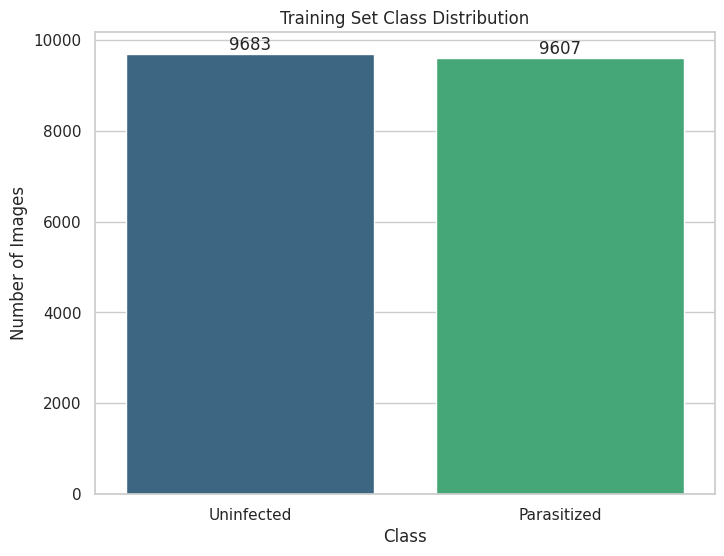

In [17]:
# Assuming you have the train labels as a list or Series
train_labels = train_df['label'].values  # Update this line based on how you're storing the labels

# Count class distribution in the training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Define class names (make sure this matches your label mapping)
classes = ['Uninfected', 'Parasitized']  # Ensure this matches the actual class names

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=12)

plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


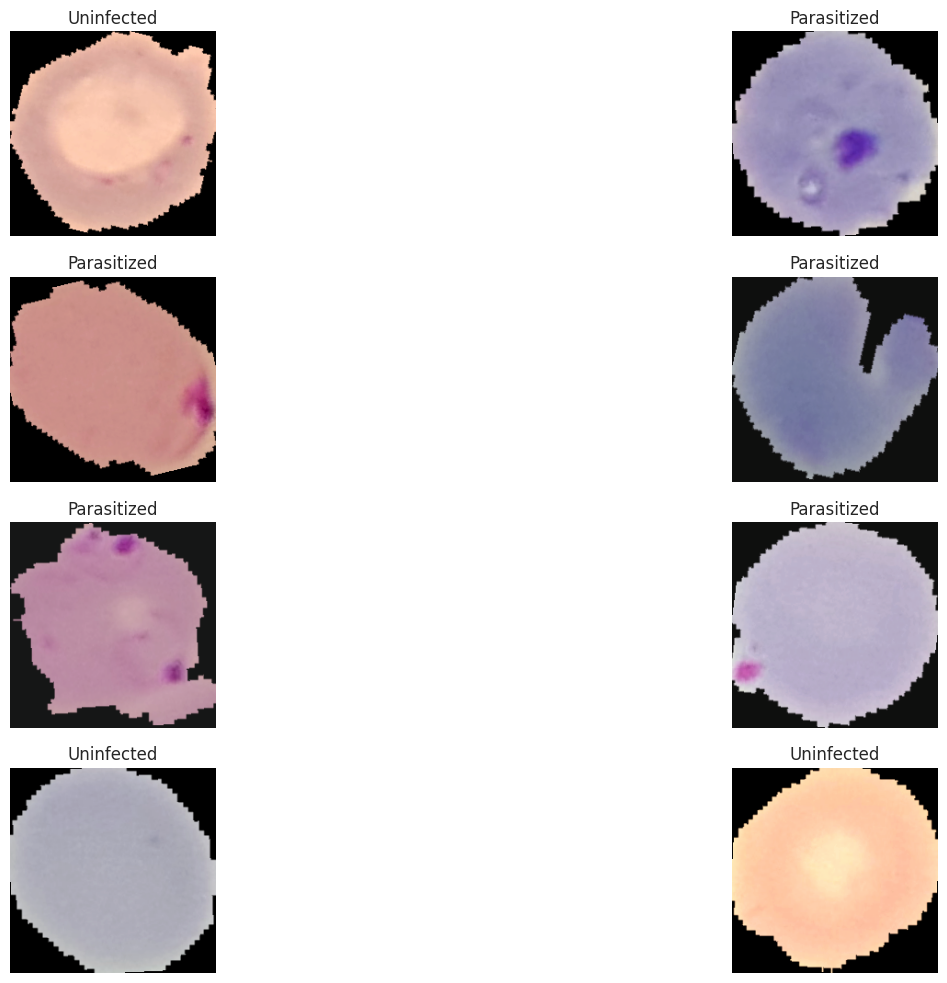

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, labels = next(iter(loader))
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, num_images//4, i+1)
        imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)


In [19]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=3ab5459132f8931ced096d377ecf0be1aefb1edecc26e60c75aae2fb827e8745
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

In [21]:
class EfficientNetB7Baseline(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB7Baseline, self).__init__()
        # Initialize EfficientNetB7 model without pre-trained weights
        self.efficientnet = EfficientNet.from_name('efficientnet-b7', num_classes=num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [22]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [23]:
class EfficientNetB7WithSE(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB7WithSE, self).__init__()
        # Initialize EfficientNetB7 model without pre-trained weights
        self.efficientnet = EfficientNet.from_name('efficientnet-b7', num_classes=num_classes)
        
        # Define an SE block
        self.se = SEBlock(channel=1536, reduction=16)  # EfficientNetB7's final block has 1536 channels

    def forward(self, x):
        # Forward through EfficientNetB7WithSE
        x = self.efficientnet.extract_features(x)  # Get features from EfficientNetB7
        x = self.se(x)  # Apply SE block
        x = self.efficientnet._avg_pooling(x)  # Average pooling
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.efficientnet._dropout(x)  # Apply dropout
        x = self.efficientnet._fc(x)  # Final fully connected layer
        return x

In [24]:
# Choose model type
model_type = 'baseline'  # Options: 'baseline', 'se'

num_classes = len(classes)

if model_type == 'baseline':
    model = EfficientNetB7Baseline(num_classes=num_classes)  # Use baseline EfficientNetB7
elif model_type == 'se':
    model = EfficientNetB7WithSE(num_classes=num_classes)  # Use EfficientNetB7 with SE block
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

EfficientNetB7Baseline(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2

In [25]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [27]:
# Define number of epochs
num_epochs = 25  # Set your desired number of epochs

# Initialize KFold for 5-fold cross-validation on the training set
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for each fold
fold_results = []

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"\nTraining for Fold {fold + 1}/{kf.n_splits}")
    
    train_fold = train_df.iloc[train_index]  # Training set for this fold
    val_fold = train_df.iloc[val_index]      # Validation set for this fold
    
    # Create datasets and loaders for each fold
    train_dataset = Malaria_Dataset(data_df=train_fold, transform=train_transform)
    val_dataset = Malaria_Dataset(data_df=val_fold, transform=val_test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Initialize a new model for this fold
    model = EfficientNetB7Baseline(num_classes=num_classes).to(device)  # or use model with SE block
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train the model
    trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

    # Store the results for this fold
    fold_results.append(history)


Training for Fold 1/5
Epoch 1/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.5928 Acc: 0.6459


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1967 Acc: 0.9497

Epoch 2/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.2015 Acc: 0.9441


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1653 Acc: 0.9533

Epoch 3/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1722 Acc: 0.9491


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1623 Acc: 0.9557

Epoch 4/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1610 Acc: 0.9528


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1314 Acc: 0.9575

Epoch 5/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1510 Acc: 0.9543


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1395 Acc: 0.9598

Epoch 6/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1460 Acc: 0.9554


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1332 Acc: 0.9578

Epoch 7/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1409 Acc: 0.9563


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1492 Acc: 0.9575

Epoch 8/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1331 Acc: 0.9589


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1251 Acc: 0.9622

Epoch 9/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1312 Acc: 0.9605


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1230 Acc: 0.9585

Epoch 10/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1266 Acc: 0.9607


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1189 Acc: 0.9640

Epoch 11/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1096 Acc: 0.9646


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1057 Acc: 0.9640

Epoch 12/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1052 Acc: 0.9659


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1070 Acc: 0.9635

Epoch 13/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1029 Acc: 0.9676


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1015 Acc: 0.9655

Epoch 14/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1013 Acc: 0.9670


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1010 Acc: 0.9660

Epoch 15/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0979 Acc: 0.9679


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0991 Acc: 0.9660

Epoch 16/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1016 Acc: 0.9672


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0992 Acc: 0.9658

Epoch 17/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0971 Acc: 0.9686


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0984 Acc: 0.9655

Epoch 18/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0935 Acc: 0.9688


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0980 Acc: 0.9666

Epoch 19/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0932 Acc: 0.9696


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0974 Acc: 0.9666

Epoch 20/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0936 Acc: 0.9692


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0985 Acc: 0.9666

Epoch 21/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0906 Acc: 0.9698


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0965 Acc: 0.9673

Epoch 22/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0913 Acc: 0.9705


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0970 Acc: 0.9676

Epoch 23/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0880 Acc: 0.9695


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0964 Acc: 0.9679

Epoch 24/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0856 Acc: 0.9712


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0966 Acc: 0.9679

Epoch 25/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.0899 Acc: 0.9713


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.0963 Acc: 0.9673

Best Validation Acc: 0.9679

Training for Fold 2/5
Epoch 1/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.6263 Acc: 0.6188


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.2224 Acc: 0.9471

Epoch 2/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.2059 Acc: 0.9415


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1516 Acc: 0.9515

Epoch 3/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1781 Acc: 0.9490


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1724 Acc: 0.9557

Epoch 4/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1593 Acc: 0.9535


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1459 Acc: 0.9515

Epoch 5/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1528 Acc: 0.9526


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1327 Acc: 0.9570

Epoch 6/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1507 Acc: 0.9555


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1326 Acc: 0.9575

Epoch 7/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1453 Acc: 0.9560


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1298 Acc: 0.9585

Epoch 8/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

Train Loss: 0.1330 Acc: 0.9573


Val:   0%|          | 0/242 [00:00<?, ?it/s]

Val Loss: 0.1338 Acc: 0.9552

Epoch 9/25
----------


Train:   0%|          | 0/965 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):  # Remove masks from unpacking
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# After training each fold's model, evaluate on the test set
# Make sure you call this function for each trained model in your cross-validation loop
evaluate_model(trained_model, test_loader, classes)

In [ ]:
def plot_history(history):
    # Check if history is not empty and has the necessary keys
    if not history or 'train_loss' not in history or 'val_loss' not in history:
        print("No history data available for plotting.")
        return

    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# After training each fold's model, you can collect and plot history
# If you want to aggregate the histories, consider modifying the training function
# to return the history for each fold

In [ ]:
def visualize_predictions(model, dataloader, classes, num_images=18):
    model.eval()
    images, labels = next(iter(dataloader))
    
    # Ensure we don't exceed the batch size
    num_images = min(num_images, images.size(0))
    
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 40))  # Adjust figsize for larger output
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 2, 2*i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.title(f"Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 18 sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=18)